In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

## Function for Meander

In [2]:
clean_positions = "./clean_positions/"
ex_buoy = pd.read_csv(clean_positions + os.listdir(clean_positions)[0])

ex_buoy = ex_buoy.set_index("datetime")

def meander(data, *, window_hours=2, continuous=False):
    """
    Requires the data to be already gridded to hourly. Produces a dataframe of meander coefficients across time.
    The date index is the mid timestamp of each window.

    data: Containing x_stere and y_stere locations of buoy
    window: In the format of pandas timedelta (e.g. '1d')
    continuous: If True, calculate on sliding window, else calculates on non-overlapping groups
    """
    def lag_distances(lag=1):
        change_squared = ((data - data.shift(lag)).dropna()[["x_stere", "y_stere"]])**2
        dists = np.sqrt(change_squared["x_stere"] + change_squared["y_stere"]).dropna()

        dists.index = pd.to_datetime(dists.index)
        return dists

    straight_line = lag_distances(lag=window_hours)
    granular = lag_distances()

    granular_sums = granular.rolling(window_hours).sum().dropna()
    coefs = granular_sums/straight_line
    answer = pd.concat([coefs, granular_sums, straight_line], axis=1)
    answer.columns = ['meander', 'granular_sums', 'straight_line']

    if not continuous:
        answer = answer.resample(f"{window_hours}h")
        answer = answer.first()

    answer.index = answer.index - pd.DateOffset(hours=window_hours*1/2)

    return answer.dropna()

## Saving all the Meanders Files

In [4]:
output_path = "./daily_meanders/"
for file in os.listdir(clean_positions):
    ex_buoy = pd.read_csv(clean_positions + file)
    ex_buoy = ex_buoy.set_index("datetime")
    meander(ex_buoy, window_hours=24).to_csv(output_path + file)

In [4]:
daily_meanders_folder = "./daily_meanders/"

meander_list = []
for file in os.listdir(daily_meanders_folder):
    meanders = pd.read_csv(daily_meanders_folder+file)
    meander_list.append(meanders)

m_df = pd.concat(meander_list)
#m_df = m_df[m_df["meander"] < 10]

m = m_df.reset_index(drop=True)["meander"]
print("Data points: ", len(m))

Data points:  181574


## Bounding Function
Only run this if you want to bound m_df by latitude and longitude

In [16]:
positions_folder = "./clean_positions/"
meander_folder = "./daily_meanders/"
meander_list = []

def bounding(lat_bounds, lon_bounds):
    for file in os.listdir(meander_folder):
        data = pd.read_csv(positions_folder+file)
        data = data.set_index("datetime")
        data.index = pd.to_datetime(data.index)

        lats = data["latitude"]
        lons = data["longitude"]

        lat_bounded = np.logical_and(lats > lat_bounds[0], lats < lat_bounds[1])
        lon_bounded = np.logical_and(lons > lon_bounds[0], lons < lon_bounds[1])
        bounded_mask = np.logical_and(lat_bounded, lon_bounded)
        
        if sum(bounded_mask) == 0:
            continue
        
        meander_data = pd.read_csv(meander_folder + file)
        meander_data = meander_data.set_index("datetime")
        meander_data.index = pd.to_datetime(meander_data.index)
        indices = meander_data.index.join(data.index, how="inner")

        meander_list.append(meander_data.loc[indices])
bounding([65,90], [-180,-160])
m_df = pd.concat(meander_list)
#m_df = m_df[m_df["meander"] < 10]

m = m_df.reset_index(drop=True)["meander"]
print("Data points: ", len(m))

Data points:  26777


## Basic Summary Stats

In [17]:
m.describe()

count    26777.000000
mean         1.483708
std          3.771535
min          1.000117
25%          1.018100
50%          1.065617
75%          1.250529
max        352.713268
Name: meander, dtype: float64

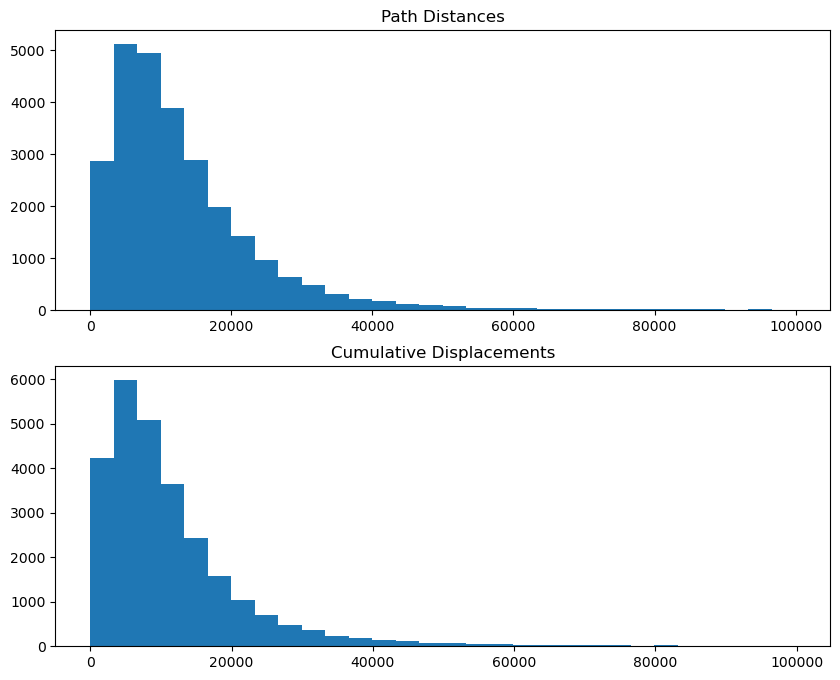

In [18]:
plt.figure(figsize=(10,8))
plt.tight_layout()
plt.subplot(2,1,1)
paths = m_df["granular_sums"]
plt.hist(paths[paths<10**5], bins=30)
plt.title("Path Distances")

plt.subplot(2,1,2)
displacements = m_df["straight_line"]
plt.title("Cumulative Displacements")
plt.hist(displacements[displacements<10**5], bins=30)

plt.show()

/tmp/ipykernel_5991/1229551568.py:12: RuntimeWarning: divide by zero encountered in log
  plt.scatter(np.log(X[:-1]), np.log(freq))
Calculating best minimal value for power law fit
/home/alanxw/.micromamba/envs/ecco-sea-ice/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
/home/alanxw/.micromamba/envs/ecco-sea-ice/lib/python3.9/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


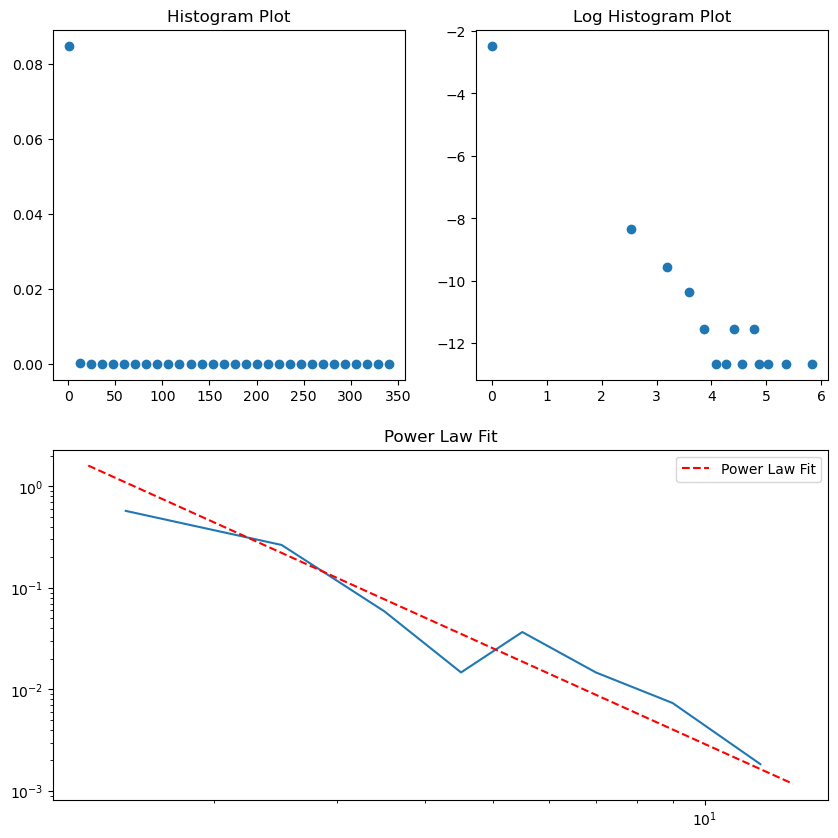

In [19]:
import powerlaw

freq, X = np.histogram(m, density=True, bins=30)

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.scatter(X[:-1], freq)
plt.title("Histogram Plot")

plt.subplot(2,2,2)
plt.scatter(np.log(X[:-1]), np.log(freq))
plt.title("Log Histogram Plot")

fit = powerlaw.Fit(data=m[:500])

plt.subplot(2,1,2)
fit.plot_pdf()
fit.power_law.plot_pdf(color='r', linestyle='--', label='Power Law Fit')
plt.title("Power Law Fit")

plt.legend()
plt.show()

## Run KS Test with powerlaw (in package function), find the best xmin
- fit.power_law.alpha gives slope param
- fit.power_law.D gives KS statistic
- A free xmin will just minimize KS
- Take repeated samples, run train test split
- Grid search xmin with ks test, check lognormal/truncated power law
- Path length and displacement length might be same family (test that)

- Weibull Distribution

In [ ]:
# Implement Here

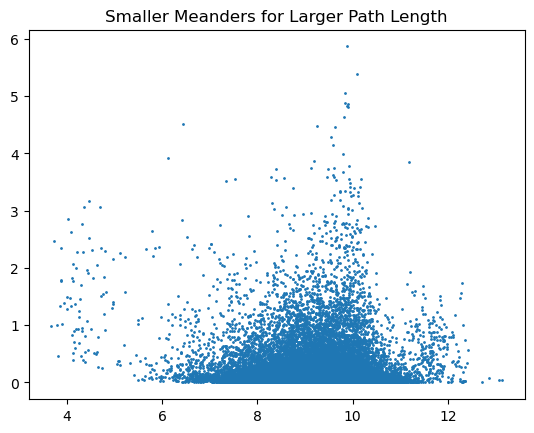

In [21]:
plt.title("Smaller Meanders for Larger Path Length")
plt.plot(np.log(m_df["granular_sums"].values), np.log(m_df["meander"].values), marker='.', ms=2, lw=0)
plt.show()

## Autocorrelation

- Randomly selecting portions of paths up to a certain length
- Calculate autocorrelation for each of those
- Calculate ensemble average

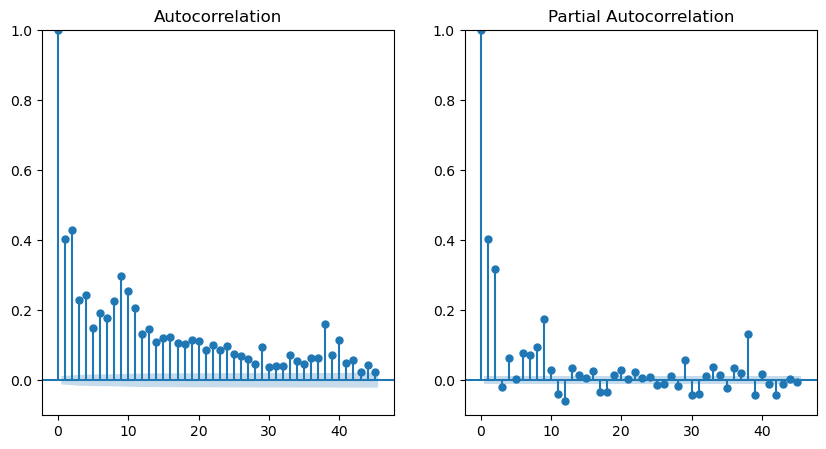

In [22]:
plt.figure(figsize=(10,5))

l = plt.subplot(1,2,1)
plot_acf(m, ax=l)
l.set_ylim([-0.1, 1])


r = plt.subplot(1,2,2)
plot_pacf(m, ax=r)
r.set_ylim([-0.1, 1])

plt.show()

## Regressing the Path Distance Against Displacement

In [23]:
import statsmodels.api as sm

X = m_df["straight_line"]
y = m_df["granular_sums"]
model = sm.OLS(y, X).fit()
nw_errors = model.get_robustcov_results(cov_type='HAC', maxlags=10)
display(nw_errors.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          granular_sums   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                              4333.
Date:                Thu, 14 Nov 2024   Prob (F-statistic):                        0.00
Time:                        10:19:06   Log-Likelihood:                     -2.7088e+05
No. Observations:               26777   AIC:                                  5.418e+05
Df Residuals:                   26776   BIC:                                  5.418e+05
Df Model:                           1                                                  
Covariance Type:                  HAC                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
straight_line     1.1640      0.018     65.827      0.000       1.129       1.199
==============================================================================
Omnibus:                    38912.669   Durbin-Watson:                   0.368
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         22780102.879
Skew:                           8.621   Prob(JB):                         0.00
Kurtosis:                     144.846   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 10 lags and without small sample correction
"""

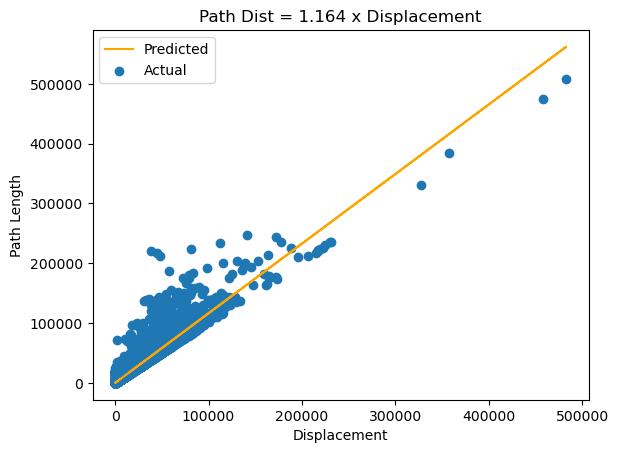

In [24]:
plt.title(f"Path Dist = {round(model.params.values[0], 4)} x Displacement")
plt.scatter(X.values, y.values, label="Actual")
plt.plot(X.values, nw_errors.predict(X).values, color="orange", label="Predicted")
plt.xlabel("Displacement")
plt.ylabel("Path Length")
plt.legend()
plt.show()

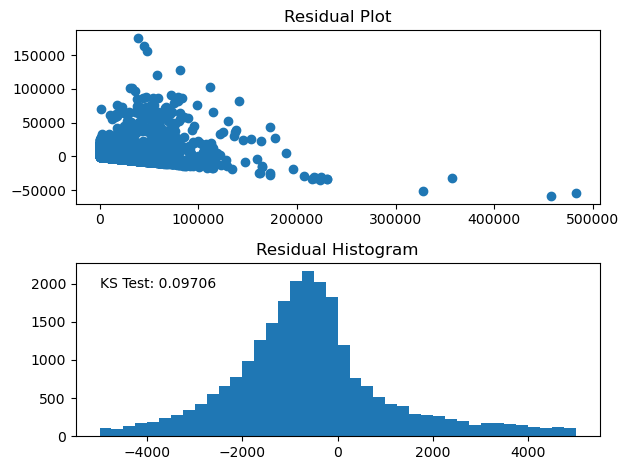

In [25]:
from scipy.stats import kstest

plt.subplot(2,1,1)
plt.scatter(X.values, model.resid.values)
plt.title("Residual Plot")
plt.subplot(2,1,2)

resids = model.resid[np.logical_and(model.resid < 5000, model.resid>-5000)]
hist = plt.hist(resids, bins=40)
print()
plt.title("Residual Histogram")
mean, std = resids.mean(), resids.std()
plt.text(min(resids.values), max(hist[0])*0.9, f"KS Test: {round(kstest(resids, 'norm', args=(mean, std)).statistic, 5)}")

plt.tight_layout()
plt.show()

## Direct Newey West

In [26]:
n = len(m)

X = sm.add_constant(np.zeros(n))
y = m

model = sm.OLS(y, X).fit()

newey_west_cov = model.get_robustcov_results(cov_type='HAC', maxlags=10).cov_params()
autocorr_adjusted_variance = np.diag(newey_west_cov)

print("Autocorrelation-Adjusted Variance:\n", autocorr_adjusted_variance)

Autocorrelation-Adjusted Variance:
 [0.00203143 0.        ]


## Grouping by Season

In [27]:
def assign_season(date):
    # Define season start and end dates for 2023 (adjust if necessary)
    if (date >= pd.Timestamp('2023-03-20') and date <= pd.Timestamp('2023-06-20')):
        return 'Spring'
    elif (date >= pd.Timestamp('2023-06-21') and date <= pd.Timestamp('2023-09-22')):
        return 'Summer'
    elif (date >= pd.Timestamp('2023-09-23') and date <= pd.Timestamp('2023-12-21')):
        return 'Autumn'
    else:
        return 'Winter'

,Autumn,Spring,Summer,Winter
count,2440.000000,1050.000000,2468.000000,20819.000000
mean,1.289043,1.130290,1.576082,1.513396
std,1.023568,0.495796,1.543051,4.226762
min,1.000156,1.000337,1.000127,1.000117
25%,1.011773,1.009258,1.049542,1.018296
50%,1.042464,1.028960,1.178132,1.065049
75%,1.169053,1.086746,1.572750,1.239900
max,26.582943,10.372757,46.688248,352.713268
Regression Estimate,1.389917,1.018508,1.185942,1.053040
Regression SE,0.107931,0.081980,0.082145,0.021622


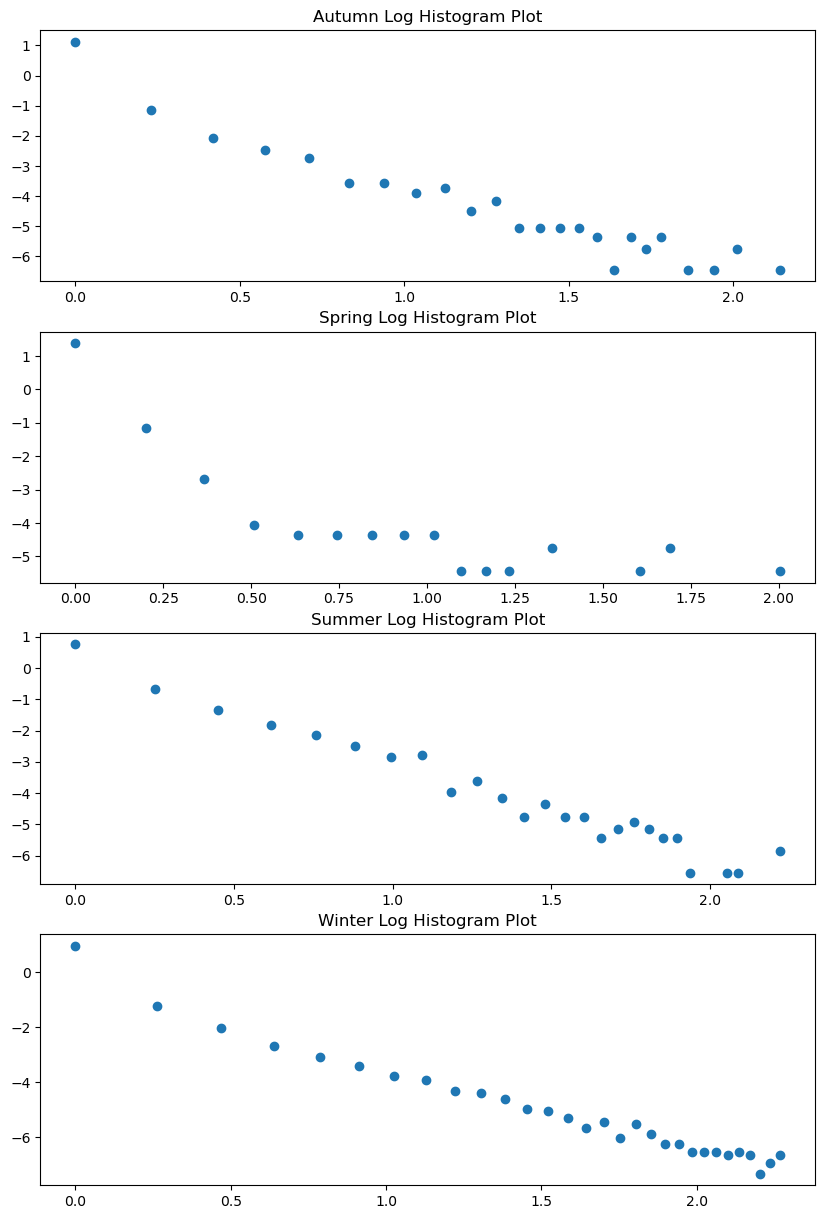

In [29]:
groups = m_df.reset_index()
groups["datetime"] = pd.to_datetime(groups["datetime"])
groups["season"] = groups["datetime"].apply(assign_season)
groups = groups.groupby("season")

m = m_df.reset_index(drop=True)["meander"]

season_dfs = []
plt.figure(figsize=(10,15))
plt.tight_layout()
for i, (season, data) in enumerate(groups):
    group_m = data.reset_index(drop=True)["meander"]
    group_m = group_m[group_m<10]
    
    freq, X = np.histogram(group_m, density=True, bins=30)


    plt.subplot(4,1,i+1)
    plt.scatter(np.log(X[:-1][freq!=0]), np.log(freq[freq!=0]))
    plt.title(f"{season} Log Histogram Plot")

    X = data["straight_line"]
    X = X - X.mean()
    y = data["granular_sums"]
    model = sm.OLS(y, X).fit()
    nw_errors = model.get_robustcov_results(cov_type='HAC', maxlags=10)
    renamed_meander = data["meander"].rename(f"{season}").describe()
    renamed_meander.loc["Regression Estimate"] = nw_errors.params[0]
    renamed_meander.loc["Regression SE"] = nw_errors.bse[0]
    season_dfs.append(renamed_meander)
    
display(pd.concat(season_dfs, axis=1))

## Uncertainty propagation
- Some meander coefficients have too much uncertainty to be considered for the average
- Total displacement for a day requires two points, confidence in distance traveled goes down as distance goes further apart
- For total path length, uncertainty goes up with each extra segment
- Figure out what the standard deviation of the buoy tech is and how that propagates into path distance and total path length
- It should be okay to assume that errors are uncorrelated at hourly time scale
- Given a meander coefficient that has uncertainty

## Getting the pdf of the meander coefficient distribution
- Getting the distribution of the two terms in the meander coefficient
    - We know the meander coefficient is autocorrelated (mean is the same)
    - Is the histogram of autocorrelated data affected?
        - Does the pdf depend on autocorrelation?
    - Estimating what the autocorrelation structure is for more buoys
        - Estimate mean and autocorrelation-adjusted variance
    - Integral timescale on acf (until first zero cross)

Time Series Analysis: Box et al.
